In [1]:
!pip install scikit-maad

     |████████████████████████████████| 134 kB 6.4 MB/s 
     |████████████████████████████████| 38.1 MB 149 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from maad import sound
from librosa import feature

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#%% Set variables
path_annotations = '/content/drive/MyDrive/DS4All - Cohort6 - Team 172/Code/ANH_RAIN_DATASET/audio_labels.csv'  # manual annotations in csv table
path_audio = '/content/drive/MyDrive/DS4All - Cohort6 - Team 172/Code/ANH_RAIN_DATASET/audio/'  # directory where the audio data is located
target_fs = 10000  # set target sampling rate for audio

In [8]:
#%% Load annotations
df = pd.read_csv(path_annotations)  

In [18]:
df.shape

(1104, 7)

In [12]:
|df.head()

,fname,label,max_f,max_t,min_f,min_t,sample_idx
0,G001_20211112_030000.WAV,SENSAT,47297.562,5.0,47297.562,0.0,0000.wav
1,G001_20211112_180000.WAV,MURCIE,44956.098,5.0,24819.512,0.0,0001.wav
2,G001_20211112_183000.WAV,INSECT,51980.490,5.0,3721.417,0.0,0002.wav
3,G001_20211112_203000.WAV,MURCIE,33482.926,5.0,16776.250,0.0,0003.wav
4,G001_20211112_220000.WAV,SENSAT,24585.365,5.0,24585.365,0.0,0004.wav


In [14]:
#%% Compute features
df_features = pd.DataFrame()

In [15]:
# Calculate for each feature, time of extraction

for idx_row, row in df.iterrows():
    full_path_audio = os.path.join(path_audio, row.sample_idx)
    s, fs = sound.load(full_path_audio)
    # resample
    s_resamp = sound.resample(s, fs, target_fs, res_type='kaiser_fast')
    # transform
    # Mel-frequency cepstral coefficients (MFCCs)
    mfcc = feature.mfcc(y=s_resamp, sr=target_fs, n_mfcc=20, n_fft=1024, 
                        win_length=1024, hop_length=512, htk=True)
    mfcc = np.median(mfcc, axis=1)
    # format dataframe
    idx_names = ['mfcc_' + str(idx).zfill(2) for idx in range(1,mfcc.size+1)]
    row = row.append(pd.Series(mfcc, index=idx_names))
    row.name = idx_row
    df_features = df_features.append(row)

In [21]:
df_features['lluvia'] = df_features['label'].apply(lambda x: 1 if x=='LLUVIA' else 0)

In [29]:
df_features.groupby(['lluvia'])[list(df_features.columns[-21:-1])].mean()

,mfcc_01,mfcc_02,mfcc_03,mfcc_04,mfcc_05,mfcc_06,mfcc_07,mfcc_08,mfcc_09,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20
lluvia,,,,,,,,,,,,,,,,,,,,
0,-417.103048,21.893770,19.196654,15.990042,-6.810938,23.961363,-18.012546,24.552419,-20.408443,19.157576,-16.170084,12.320578,-11.060503,6.522422,-7.176486,2.597697,-4.779024,0.936375,-3.855728,0.400896
1,-228.229129,17.585196,-17.380748,28.468047,-23.160937,14.657020,-23.085880,11.295486,-21.064453,10.982973,-15.714040,6.461366,-13.591282,5.507023,-11.864115,4.718177,-9.010211,2.887038,-6.838571,2.337560


In [ ]:
#%% Split development and test data
X = df_features.loc[:,df_features.columns.str.startswith('mfcc')]
y = (df_features.label=='LLUVIA').astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=42)



In [ ]:
#%% Tune model hyperparameters
clf = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample')


# Set tuning strategy
param_grid = {'n_estimators' : [1, 5, 10, 100, 300, 500],
              'max_features' : [2, 6, 10, 14, 18]}

skf = StratifiedKFold(n_splits=10)
clf_gs = GridSearchCV(clf, param_grid, scoring=['f1'], 
                           refit='f1', cv=skf, return_train_score=True,
                           n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [ ]:
#%% Evaluation: compute metrics, error analysis
print('Mean cross-validated score of the best_estimator:', clf_gs.best_score_)
print('Parameter setting that gave the best results on hold out data', clf_gs.best_params_)

Mean cross-validated score of the best_estimator: 0.8342702282371359
Parameter setting that gave the best results on hold out data {'max_features': 6, 'n_estimators': 100}


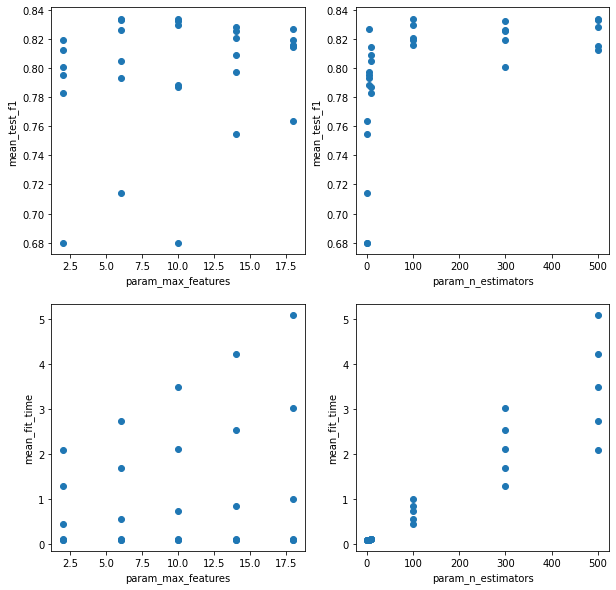

In [ ]:
# Plots to explore results of cross-validation
params = ['param_max_features', 'param_n_estimators']
metrics = ['mean_test_f1', 'mean_fit_time']
fig, ax = plt.subplots(2,2, figsize=[10,10])

ax[0,0].plot(clf_gs.cv_results_[params[0]].tolist(), clf_gs.cv_results_[metrics[0]], 'o')
ax[0,0].set_xlabel(params[0]); ax[0,0].set_ylabel(metrics[0]);

ax[0,1].plot(clf_gs.cv_results_[params[1]].tolist(), clf_gs.cv_results_[metrics[0]], 'o')
ax[0,1].set_xlabel(params[1]); ax[0,1].set_ylabel(metrics[0]);

ax[1,0].plot(clf_gs.cv_results_[params[0]].tolist(), clf_gs.cv_results_[metrics[1]], 'o')
ax[1,0].set_xlabel(params[0]); ax[1,0].set_ylabel(metrics[1]);

ax[1,1].plot(clf_gs.cv_results_[params[1]].tolist(), clf_gs.cv_results_[metrics[1]], 'o')
ax[1,1].set_xlabel(params[1]); ax[1,1].set_ylabel(metrics[1]);



In [ ]:
#%% Final evaluation on test data
y_pred = clf_gs.predict(X_test)
score = f1_score(y_test, y_pred)

In [ ]:
score

0.8656716417910447